In [125]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler #Standardisation
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier #for Voting Classifier

from sklearn.metrics import accuracy_score,recall_score, confusion_matrix, roc_curve \
,average_precision_score, precision_recall_curve, precision_score, f1_score


In [4]:
dia = pd.read_csv('diabetes.csv')

In [8]:
dia.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
dia.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

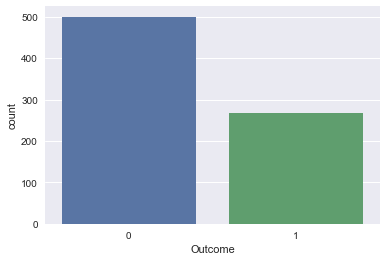

In [14]:
sns.countplot(x='Outcome',data=dia)


In [49]:
columns=dia.columns[:8]

length=len(columns)

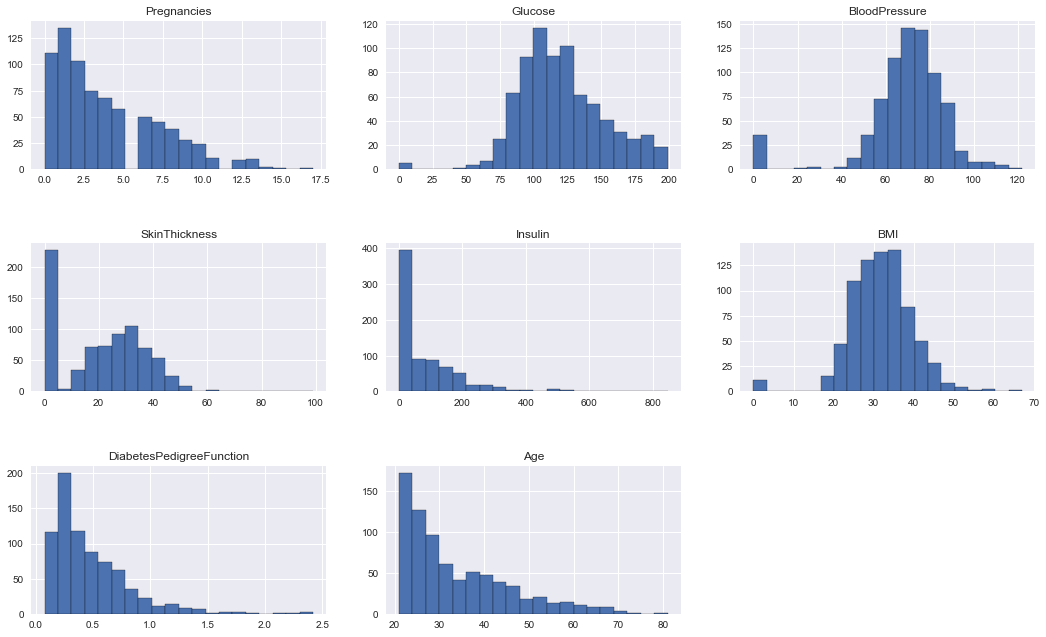

In [54]:
plt.subplots(figsize=(18,15))
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    dia[i].hist(bins=20,edgecolor='black')
    plt.title(i)

In [ ]:
sns.pairplot(dia, hue="Outcome", diag_kind='kde')

# Correlations

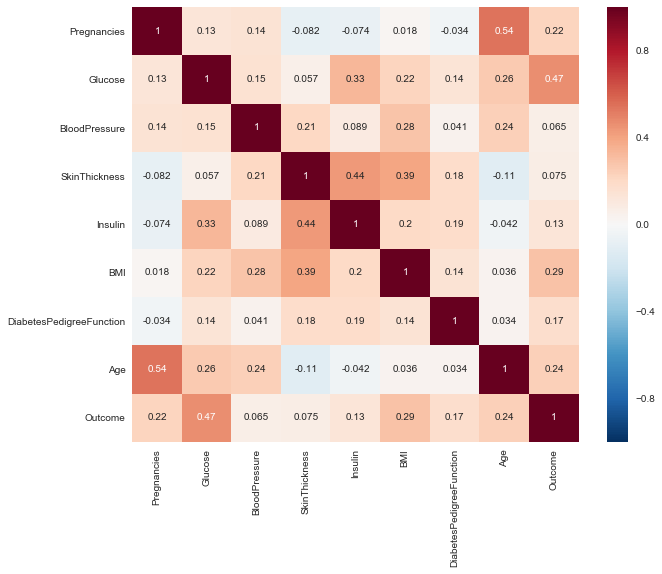

In [72]:
sns.heatmap(dia.corr(),annot=True)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

# Cross Validation

In [77]:
Outcome=dia['Outcome']
variables=dia[dia.columns[:8]]
train,test=train_test_split(dia,test_size=0.25,random_state=0,stratify=dia['Outcome'])# stratify the outcome
train_X=train[train.columns[:8]]
test_X=test[test.columns[:8]]
train_Y=train['Outcome']
test_Y=test['Outcome']

# Model Evaluation

In [91]:
#defining a metrics function to evaluate a model
def Metrics(ytest,pred):
    print('accuray:', accuracy_score(ytest,pred),',recall score:',recall_score(ytest,pred),'\n ConfusionMatrix: \n',confusion_matrix(ytest,pred))
    #model_rf.feature_importances_
    average_precision = average_precision_score(ytest,pred)
    print('average_precision_score: ',average_precision_score(ytest,pred))
    print('Precision Score:',precision_score(ytest,pred),'F1_score:',f1_score(ytest,pred))
    
    precision, recall,_ = precision_recall_curve(ytest,pred)
    plt.step(recall,precision, color='b',alpha = 0.2, where = 'post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,\
                     color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(\
              average_precision))
    #plt.title(algo)

# ML Modelling

accuray: 0.75 ,recall score: 0.641791044776 
 ConfusionMatrix: 
 [[101  24]
 [ 24  43]]
average_precision_score:  0.704291044776
Precision Score: 0.641791044776 F1_score: 0.641791044776


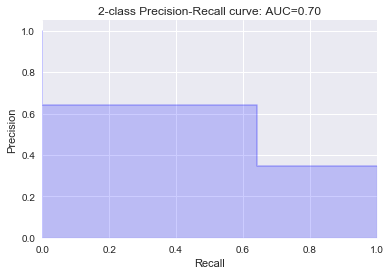

In [94]:
#decision tree classifier
DT = DecisionTreeClassifier(random_state=12)
model_dt = DT.fit(train_X,train_Y)
pred_dt=model_dt.predict(test_X)
Metrics(test_Y,pred_dt)


accuray: 0.796875 ,recall score: 0.641791044776 
 ConfusionMatrix: 
 [[110  15]
 [ 24  43]]
average_precision_score:  0.75408517756
Precision Score: 0.741379310345 F1_score: 0.688


Glucose                     0.248072
BMI                         0.162516
Age                         0.144339
DiabetesPedigreeFunction    0.126782
BloodPressure               0.089978
Pregnancies                 0.083794
Insulin                     0.073861
SkinThickness               0.070659
dtype: float64

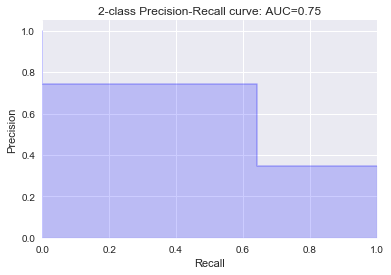

In [111]:
#random forest 
rf = RandomForestClassifier(n_estimators=300,random_state=72)
model_rf = rf.fit(train_X,train_Y)
pred_rf = model_rf.predict(test_X)
Metrics(test_Y,pred_rf)
pd.Series(model_rf.feature_importances_,train_X.columns ).sort_values(ascending= False)

accuray: 0.765625 ,recall score: 0.626865671642 
 ConfusionMatrix: 
 [[105  20]
 [ 25  42]]
average_precision_score:  0.717246679907
Precision Score: 0.677419354839 F1_score: 0.651162790698


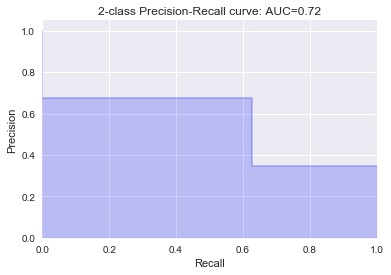

In [105]:
#gaussian naive bayes
gnb = GaussianNB()
modelgnb = gnb.fit(train_X,train_Y)
pred_gnb = modelgnb.predict(test_X)
Metrics(test_Y,pred_gnb)


accuray: 0.776041666667 ,recall score: 0.582089552239 
 ConfusionMatrix: 
 [[110  15]
 [ 28  39]]
average_precision_score:  0.725072553897
Precision Score: 0.722222222222 F1_score: 0.644628099174


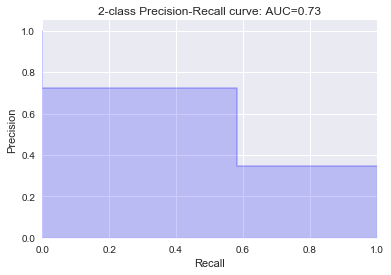

In [106]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
Metrics(test_Y,prediction)

# Feature selection based on correlation and RF feature importance

In [116]:
dia2=dia[['Glucose','BMI','Age','DiabetesPedigreeFunction','Outcome']]
features=dia2[dia2.columns[:4]]
features_standard=StandardScaler().fit_transform(features)# Gaussian Standardisation
x=pd.DataFrame(features_standard,columns=[['Glucose','BMI','Age','DiabetesPedigreeFunction']])
x['Outcome']=dia2['Outcome']
outcome=x['Outcome']
train1,test1=train_test_split(x,test_size=0.25,random_state=0,stratify=x['Outcome'])
train_X1=train1[train1.columns[:4]]
test_X1=test1[test1.columns[:4]]
train_Y1=train1['Outcome']
test_Y1=test1['Outcome']

# Evaluating for multiple models

In [117]:
def model_comparison(X_train,X_test, y_train,y_test):
    lr = LogisticRegression()
    gnb = GaussianNB()
    svc = LinearSVC(C=1.0)
    rfc = RandomForestClassifier(n_estimators=100)
    
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),\
                      (gnb, 'Naive Bayes'),\
                      (svc, 'Support Vector Classification'),\
                      (rfc, 'Random Forest')]:
        clf.fit(X_train, y_train)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)
    
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name, ))
    
        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)
    
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    
    plt.tight_layout()
    plt.show()

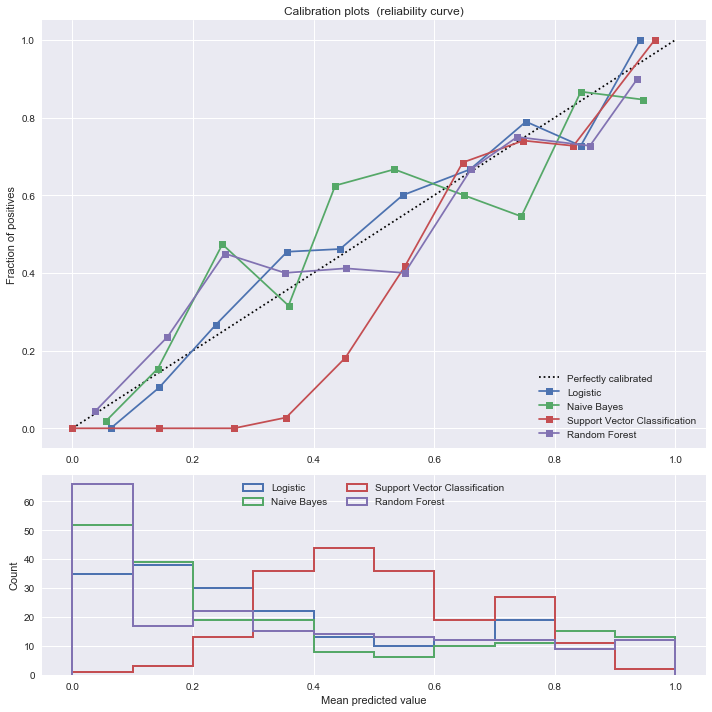

In [121]:
model_comparison(train_X1,test_X1,train_Y1,test_Y1)

accuray: 0.776041666667 ,recall score: 0.582089552239 
 ConfusionMatrix: 
 [[110  15]
 [ 28  39]]
average_precision_score:  0.725072553897
Precision Score: 0.722222222222 F1_score: 0.644628099174


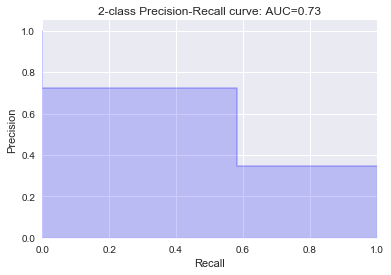

In [122]:
model = LogisticRegression()
model.fit(train_X1,train_Y1)
prediction=model.predict(test_X1)
Metrics(test_Y1,prediction)

In [126]:
linear_svc=svm.SVC(kernel='linear',C=0.1,gamma=10,probability=True)
radial_svm=svm.SVC(kernel='rbf',C=0.1,gamma=10,probability=True)
lr=LogisticRegression(C=0.1)

# Ensemble

<b> Combining linear and logistic regression

In [130]:
ensemble_lin_lr=VotingClassifier(estimators=[('Linear_svm', linear_svc), ('Logistic Regression', lr)], 
                       voting='soft', weights=[2,1]).fit(train_X1,train_Y1)
print('The accuracy for Linear SVM and Logistic Regression is:',ensemble_lin_lr.score(test_X1,test_Y1))

The accuracy for Linear SVM and Logistic Regression is: 0.78125
